# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



In [1]:
from ema_workbench import Model, RealParameter, ScalarOutcome, perform_experiments, Policy
from scipy.optimize import brentq
import numpy as np


from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

from lakemodel_function import lake_problem
lake_model = Model('lakeproblem', function=lake_problem)

# defining uncertainties 
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# define outcomes
lake_model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

# we use time_horizon here
lake_model.time_horizon = 100

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in range(lake_model.time_horizon)] 

In [2]:
#making the policies

policy_norelease = Policy("no release", **{l.name:0 for l in lake_model.levers}) 
policy_half = Policy("half", **{l.name:0.05 for l in lake_model.levers})
policy_max = Policy("max", **{l.name:0.1 for l in lake_model.levers})
policies = [policy_norelease, policy_half, policy_max]

In [3]:
#Perform experiments
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments)

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


[MainProcess/INFO] no time dimension found in results


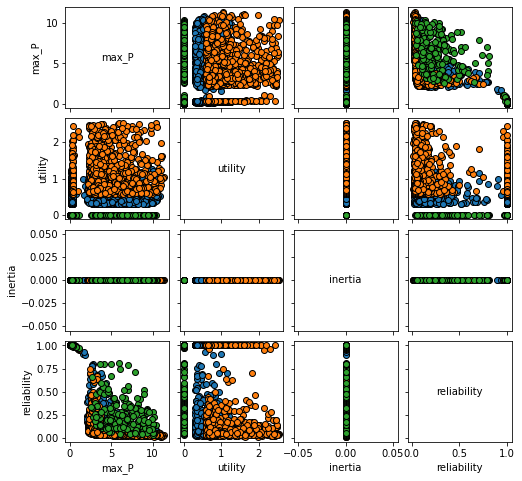

In [4]:
#Plotting results
from ema_workbench.analysis import pairs_plotting
import matplotlib.pyplot as plt

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='policy',
                                         legend=False)
fig.set_size_inches(8,8)
plt.show()

In [30]:
#Using Sobol sampling
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments_sobol, outcomes_sobol = evaluator.perform_experiments(scenarios=1000, policies=policies, 
                                                                      uncertainty_sampling='sobol')

[MainProcess/INFO] pool started
C:\ProgramData\Anaconda3\lib\site-packages\SALib\sample\saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 12000 scenarios * 3 policies * 1 model(s) = 36000 experiments
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 21600 cases completed
[MainProcess/INFO] 25200 cases completed
[MainProcess/INFO] 28800 cases completed
[MainProcess/INFO] 32400 cases completed
[MainProcess/INFO] 36000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [6]:
#define problem
problem = get_SALib_problem(lake_model.uncertainties)

In [32]:
# P1 Sobol
p1=outcomes_sobol['reliability'][0:12000]
Si_1000 = sobol.analyze(problem, p1, calc_second_order=True)

import pandas as pd

Si_filter = {k:Si_1000[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
b,0.713944,0.083033,0.348507,0.069702
delta,0.000023,0.000012,-0.000052,0.000311
mean,0.324437,0.050365,0.088010,0.048893
q,0.485617,0.066851,0.156889,0.070539
stdev,0.000040,0.000030,0.000233,0.000517


In [33]:
# P2 Sobol
p2=outcomes_sobol['reliability'][12000:24000]
Si_1000 = sobol.analyze(problem, p2, calc_second_order=True)

import pandas as pd

Si_filter = {k:Si_1000[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
b,0.739087,0.051043,0.522336,0.066716
delta,0.000009,0.000006,-0.000065,0.000266
mean,0.130761,0.023382,0.033505,0.032015
q,0.457473,0.053469,0.239248,0.060271
stdev,0.000024,0.000018,0.000257,0.000484


In [36]:
# P3 Sobol
p3=outcomes_sobol['reliability'][24000:36000]
Si_1000 = sobol.analyze(problem, p2, calc_second_order=True)

import pandas as pd

Si_filter = {k:Si_1000[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
b,0.739087,0.054291,0.522336,0.060543
delta,0.000009,0.000006,-0.000065,0.000259
mean,0.130761,0.023651,0.033505,0.031021
q,0.457473,0.043149,0.239248,0.060171
stdev,0.000024,0.000019,0.000257,0.000451


Both policies in which pollution is present affects the sensitivity of the model outcomes to the parameters, however the difference between the sensitivities of the two pollution policies is minimal

2. Repeat the above analysis for the 3 release policies but now with extra
trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*


In [60]:
#Using Latin Hypercube sampling for extra trees
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments_LHS, outcomes_LHS = evaluator.perform_experiments(scenarios=1000, policies=policies, 
                                                                      uncertainty_sampling=LHS)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [61]:
#clean experiments
cleaned = experiments_LHS.loc[:, [u.name for u in lake_model.uncertainties]]

max_P 0
              1
0              
b      0.614274
mean   0.166902
q      0.149672
stdev  0.036846
delta  0.032307
 


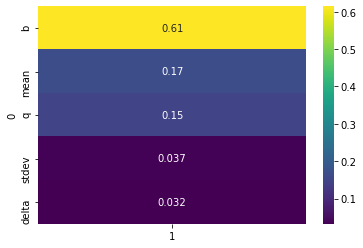

utility 0
         1
0         
b      0.0
q      0.0
mean   0.0
stdev  0.0
delta  0.0
 


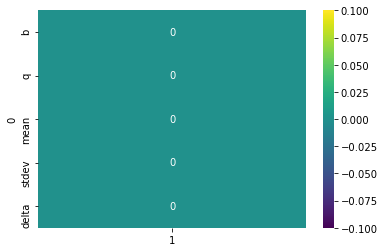

inertia 0
         1
0         
b      0.0
q      0.0
mean   0.0
stdev  0.0
delta  0.0
 


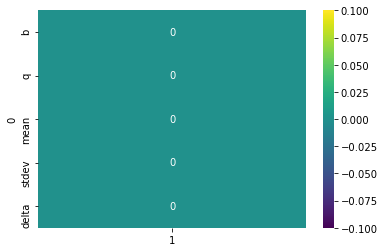

reliability 0
              1
0              
b      0.466336
q      0.260399
mean   0.204385
delta  0.035711
stdev  0.033169
 


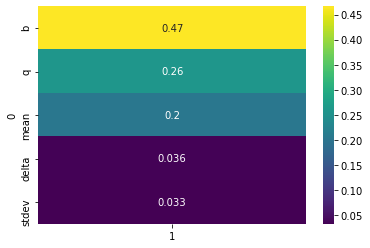

max_P 1
              1
0              
b      0.866450
q      0.069854
mean   0.031537
delta  0.016499
stdev  0.015660
 


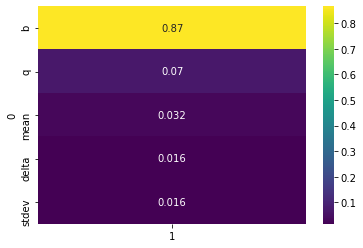

utility 1
              1
0              
delta  0.965437
b      0.009338
mean   0.008781
q      0.008565
stdev  0.007878
 


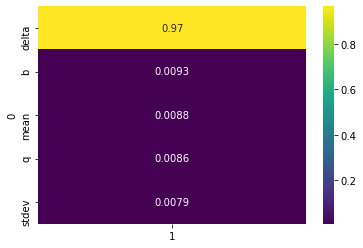

inertia 1
         1
0         
b      0.0
q      0.0
mean   0.0
stdev  0.0
delta  0.0
 


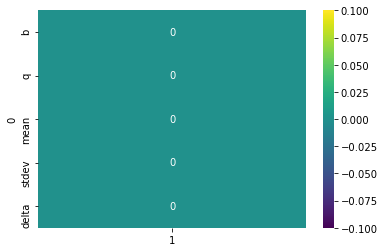

reliability 1
              1
0              
b      0.548515
q      0.323925
mean   0.075966
stdev  0.027252
delta  0.024342
 


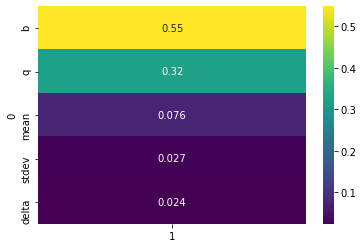

max_P 2
              1
0              
b      0.927823
q      0.030694
mean   0.017876
stdev  0.012339
delta  0.011269
 


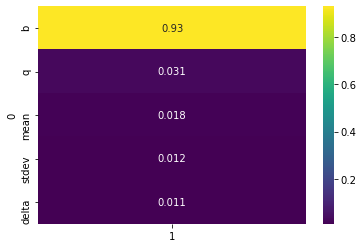

utility 2
              1
0              
delta  0.965756
stdev  0.008954
mean   0.008572
b      0.008512
q      0.008206
 


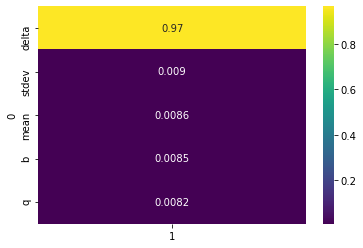

inertia 2
         1
0         
b      0.0
q      0.0
mean   0.0
stdev  0.0
delta  0.0
 


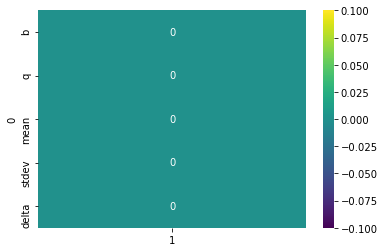

reliability 2
              1
0              
b      0.521292
q      0.336261
mean   0.071029
stdev  0.037032
delta  0.034385
 


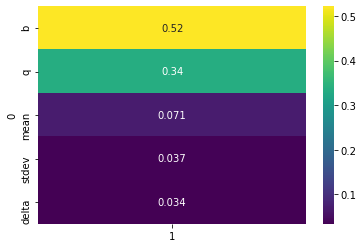

In [94]:
# Use extra trees
import seaborn as sns 

for i in range(3):
    for outcome in ['max_P','utility','inertia','reliability']:
        fs, alg = feature_scoring.get_ex_feature_scores(cleaned[i*1000:(i+1)*1000], 
                                                        outcomes_LHS[outcome][i*1000:(i+1)*1000], 
                                                        mode=RuleInductionType.REGRESSION, nr_trees = 100, max_features=0.6)
        g=str(outcome)+str(i)
        g=sns.heatmap(fs, cmap='viridis', annot=True)
        print(outcome,i)
        print(fs)
        print(' ')
        plt.show()

- Inertia: no difference all 0
- Reliability: order of importance of the parameters was the same for all policies using both extra trees and sobol analysis. Overall the parameter sensitivity varies more using extra trees (specifically between policy = 0.05 and policy = 0.1)
- Utility: none for policy=0, and almost no variation between the two policies where pollution is present
- Max P: the most important parameter in influencing the Max P is the lake's natural removal rate (b) while the sensitivity to the other parameters decreases throughout
  - The results from the Max P were surprising as we would not have been able to make these conclusions by just looking at the     model